In [ ]:
import sys
import numpy as np
import pandas as pd
import cv2
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
#from keras.optimizers import Adam
#from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
#from keras.models import Model
'''
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
'''

from sklearn.utils import shuffle



In [ ]:
def read_images(image_directory_path):
    """
    Reads all the images from a given directory
    """
    datax = []
    datay = []
    classes= os.listdir(image_directory_path)
    for item in classes:
        images = os.listdir(image_directory_path + item + '/')
        for img in images:
            image_directory_name=img
            image = cv2.resize(
                cv2.imread(image_directory_path + item + '/' + img),
                (200,200)
                )
            #rotations of image
            '''
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            '''
            datax.append(image)
            datay.append(image_directory_path+item+'/'+img)
    return np.array(datax), np.array(datay)

In [ ]:
image_directory_path=r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Learning_Data/"
trainx,trainy=read_images(image_directory_path=image_directory_path)


In [ ]:
trainx.shape

(50, 200, 200, 3)

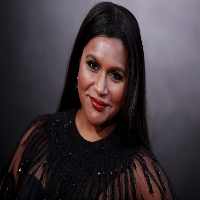

In [94]:
cv2_imshow(trainx[10])

In [ ]:
train_classes=os.listdir(r"/content/drive/MyDrive/Smart_Glasses/Few_Shot_Learning_Data")

In [256]:
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Flatten, Dense, Input

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras import backend as K

In [264]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu',kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',kernel_regularizer=l2(1e-3)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [265]:
model = get_siamese_model((200,200, 3))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 4096)         304250176   input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4096)         0           sequential_10[0][0]        

In [260]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [ ]:
import numpy.random as rng

In [246]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = trainx
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes=len(train_classes)
    n_examples=5
    a,w,h,b = X.shape
    
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    #pairs=[np.zeros((batch_size, h, w,b)) for i in range(2)]
    pairs=[]
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        temp=[]
        category =categories[i]
        idx_1 = rng.randint(0, n_examples)
        temp.append(X[category*5+idx_1])
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        ind1=0
        if i >= batch_size // 2:
            ind1=category 
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            ind1=(category + rng.randint(1,n_classes)) % n_classes
        
        temp.append(X[ind1*5+idx_2-1])
        pairs.append(temp)
    
    return np.array(pairs),np.array(targets)

In [112]:
a,b=get_batch(4)

In [113]:
b

array([0., 0., 1., 1.])

In [114]:
from google.colab.patches import cv2_imshow

In [115]:
a.shape

(4, 2, 200, 200, 3)

In [116]:
a[0][1].shape

(200, 200, 3)

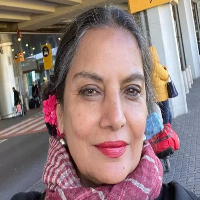

In [123]:
cv2_imshow(a[3][0])

In [124]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [134]:
valx,valy=read_images(r"/content/drive/MyDrive/Smart_Glasses/Test_Set/")

In [135]:
valx.shape

(10, 200, 200, 3)

In [136]:
val_classes=os.listdir(r"/content/drive/MyDrive/Smart_Glasses/Test_Set")

In [232]:
def make_oneshot_task(N, s="val"):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = valx
        categories = val_classes
        n_classes=len(val_classes)
        n_examples=2
        a,w,h,b = X.shape
    indices = rng.randint(0, n_examples,size=(N,))
    categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    #test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    test_image=X[true_category*2+ex1]
    test_image=np.array(test_image)
    support_set=[]
    support_set.append(test_image)
    support_set.append(X[true_category*2+ex2])
    for i in range(len(categories)):
      for item in range(n_examples):
        if i==0:
          break
        elem=X[categories[i]*2+item]
        support_set.append(elem)
    #support_set = X[categories*2indices,:,:]
    #support_set[0,:,:] = X[true_category,ex2]
    #support_set = support_set.reshape(N, w, h,1)
    support_set=np.array(support_set)
    targets = np.zeros((N*2-1,))
    targets[0] = 1
    
    

    return support_set, targets

In [233]:
p,q,r=make_oneshot_task(5)

In [234]:
q.shape

(9, 200, 200, 3)

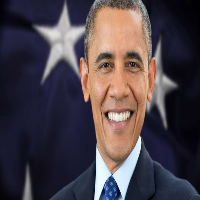

In [235]:
cv2_imshow(p)

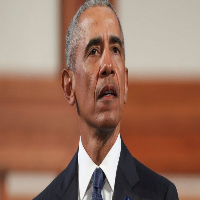

In [237]:
cv2_imshow(q[0])

In [217]:
r[1]

0.0

In [238]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [239]:
q.shape

(9, 200, 200, 3)

In [242]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 4
n_iter = 20000 # No. of training iterations
N_way = 10 # how many classes for testing one-shot tasks
n_val =5 # how many one-shot tasks to validate on
best = -1

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    #print(inputs.shape)
    
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc
    '''



In [290]:
w=[]
for item in inputs:
  a,b=item[0],item[1]
  w.append(a)
  w.append(b)
  break
w

[array([[[64, 46, 45],
         [63, 45, 44],
         [63, 45, 44],
         ...,
         [59, 43, 44],
         [59, 43, 44],
         [58, 42, 43]],
 
        [[64, 46, 45],
         [65, 47, 46],
         [65, 47, 46],
         ...,
         [59, 43, 44],
         [59, 43, 44],
         [58, 42, 43]],
 
        [[64, 46, 45],
         [64, 46, 45],
         [64, 46, 45],
         ...,
         [60, 44, 45],
         [60, 44, 45],
         [59, 43, 44]],
 
        ...,
 
        [[65, 47, 46],
         [64, 46, 45],
         [67, 49, 48],
         ...,
         [63, 53, 53],
         [63, 53, 53],
         [65, 55, 55]],
 
        [[63, 45, 44],
         [64, 46, 45],
         [63, 45, 44],
         ...,
         [70, 60, 60],
         [70, 60, 60],
         [69, 59, 59]],
 
        [[63, 45, 44],
         [63, 45, 44],
         [63, 45, 44],
         ...,
         [69, 59, 59],
         [62, 52, 52],
         [68, 58, 58]]], dtype=uint8), array([[[ 22, 237, 194],
         [  3, 17

In [261]:
loss = model.train_on_batch(w, targets[0])

IndexError: ignored

In [296]:
a=w[0]
a=tf.convert_to_tensor(a,dtype='float')

In [298]:
a=tf.reshape(a,(-1,200,200,3))

In [299]:
a

<tf.Tensor: shape=(1, 200, 200, 3), dtype=float32, numpy=
array([[[[64., 46., 45.],
         [63., 45., 44.],
         [63., 45., 44.],
         ...,
         [59., 43., 44.],
         [59., 43., 44.],
         [58., 42., 43.]],

        [[64., 46., 45.],
         [65., 47., 46.],
         [65., 47., 46.],
         ...,
         [59., 43., 44.],
         [59., 43., 44.],
         [58., 42., 43.]],

        [[64., 46., 45.],
         [64., 46., 45.],
         [64., 46., 45.],
         ...,
         [60., 44., 45.],
         [60., 44., 45.],
         [59., 43., 44.]],

        ...,

        [[65., 47., 46.],
         [64., 46., 45.],
         [67., 49., 48.],
         ...,
         [63., 53., 53.],
         [63., 53., 53.],
         [65., 55., 55.]],

        [[63., 45., 44.],
         [64., 46., 45.],
         [63., 45., 44.],
         ...,
         [70., 60., 60.],
         [70., 60., 60.],
         [69., 59., 59.]],

        [[63., 45., 44.],
         [63., 45., 44.],
         [63., 4

In [308]:
h=tf.keras.layers.Conv2D(10,(1,1))(a)

In [309]:
h

<tf.Tensor: shape=(1, 200, 200, 10), dtype=float32, numpy=
array([[[[-15.139463 ,  14.066864 ,  24.645794 , ..., -54.145912 ,
           37.062813 ,  18.272238 ],
         [-15.072538 ,  13.762847 ,  24.010849 , ..., -53.01333  ,
           36.498253 ,  17.822763 ],
         [-15.072538 ,  13.762847 ,  24.010849 , ..., -53.01333  ,
           36.498253 ,  17.822763 ],
         ...,
         [-13.323738 ,  13.253721 ,  23.917387 , ..., -51.474148 ,
           33.61332  ,  17.328388 ],
         [-13.323738 ,  13.253721 ,  23.917387 , ..., -51.474148 ,
           33.61332  ,  17.328388 ],
         [-13.256813 ,  12.949704 ,  23.282442 , ..., -50.34156  ,
           33.048763 ,  16.878914 ]],

        [[-15.139463 ,  14.066864 ,  24.645794 , ..., -54.145912 ,
           37.062813 ,  18.272238 ],
         [-15.2063875,  14.370882 ,  25.280737 , ..., -55.278503 ,
           37.62737  ,  18.721712 ],
         [-15.2063875,  14.370882 ,  25.280737 , ..., -55.278503 ,
           37.62737  ,  18